## About
This analysis script lets you post-process the TMaMD results. You require:
- `{workdir}/data/pyrosetta/combined.out`
- `{workdir}/data/iter*/mount/xtc/*`<br/>
from the runs.
- Reference PDB structure (clean - only RNA present) to compare<br/>

You can get all files by running `examples/scripts/get_TMaMD_files.sh` after changing the servers and the path.<br/>
This notebook can be used if you have missing atoms or mismatches between your trajectory and reference PDB with much less human intervention.<br/>

**Note:** Some parts of this code may be sensitive to the RNA chosen. These regions are marked out with a <i>'#TODO: Change accordingly'</i> tag

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import os
%run ../PyRosetta/General.ipynb

/home/venkata/micromamba/thermomaps/lib/python3.10/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│              See LICENSE.md or email license@uw.edu for details              │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.08+release.717d2e8232174371f0c672564f23a097062db88a 2024-02-21T10:16:44] retrieved from: http://www.pyrosetta.org


### Setting root dir
This is where all your 'iter' folders are present.

In [2]:
ROOT_DIR="/home/venkata/python/PyRosetta/R1107/server/example5/" #TODO: Change Accordingly
sorted(os.listdir(ROOT_DIR))

['get_TMaMD_files.sh',
 'iter0',
 'iter1',
 'iter2',
 'iter3',
 'iter4',
 'iter5',
 'iter6',
 'iter7',
 'rosetta']

## Picking the reference
There are **two** use cases here. Pick the next cell based on which mode you want to run in

### Crystal Structure PDB
Run the next cell if you want to comapre RMSD to <b>Experimental Crystal Structure PDB</b>

In [3]:
ref_pose=LoadedPDB(ROOT_DIR+"../../7qr4_clean_noprotein.pdb") #TODO: Change accordingly (Path to your crystal PDB)
ANALYSIS_TYPE="crystal"

### Rosetta Best PDB
Run the next cell if you want to compare RMSD of TMaMD MD runs to <b>Rosetta's best prediction</b>

In [ ]:
ref_pose=LoadedPDB(ROOT_DIR+"/rosetta/crystal_closest.pdb") #Picks up the rosetta best crystal structure
# Note: You need to generate this by doing the rosetta analysis. Look at the Rosetta_PostProcess.ipynb file for this
ANALYSIS_TYPE="rosetta"

### Next Steps

#### Locating the 'iter' folders

In [4]:
iter_fols=np.array(sorted([dir for dir in os.listdir(ROOT_DIR) if dir.startswith("iter")]),dtype=str)
SKIP_LAST=False #TODO: Change accordingly (Useful if the simulations were stopped midway, so last iteration did not complete)
print(iter_fols)

['iter0' 'iter1' 'iter2' 'iter3' 'iter4' 'iter5' 'iter6' 'iter7']


#### Using 'top.pdb' as the template frame to get atoms

In [5]:
fol=iter_fols[0]
folpath=ROOT_DIR+"/"+fol+"/mount/xtc/"
md_xtc=LoadedXTC(folpath+"/cluster0.xtc",folpath+"/top.pdb")
ref_xyz_base=get_torch_rep(ref_pose,ignore_Hs=False).cpu().numpy()

#### Computing RMSD for each structure in each cluster
This is much slower than the previous one, but does not require atoms to match-up before hand

In [22]:
import time
start_time=time.time()
for fol in iter_fols:
    # Go through each iteration (folder-wise)
    folpath=ROOT_DIR+"/"+fol+"/mount/xtc/"
    print(fol,end=":\n")
    cluster_id=[]
    cluster_rmsds=[]
    # Go through each cluster for that iteration
    clusters=sorted([fol for fol in os.listdir(folpath) if fol.endswith(".xtc")])
    for cluster in clusters:
        # Pick only xtc files
        if not cluster.endswith(".xtc") or not cluster.startswith("cluster"): continue
        cluster_rmsds.append([])
        cluster_id.append(cluster)
        
        # Load the trajectory
        md_xtc=LoadedXTC(folpath+"/"+cluster,folpath+"/top.pdb")
        match_memory=None

        print("\t",cluster," ",len(md_xtc),"frames","...",end=" ")

        # For each structure in the cluster
        for i,frame in enumerate(md_xtc):
            # Match the atoms
            if i==0:
                m1,m2=match_atoms(ref_pose,frame.pose(),skipH=True,filter_2=md_xtc.found_atoms)
                match_memory=(m1,m2)
            else:
                m1,m2=match_memory[0],match_memory[1]

            # Check all atoms match-up
            assert np.all(frame.pose().get_atom_names()[m2]==ref_pose.get_atom_names()[m1])
            
            # Get the atom coordinates
            r1=ref_xyz_base[m1]
            r2=get_torch_rep(frame.pose(),ignore_Hs=False).cpu().numpy()[m2]
            
            # Align and get RMSD value
            rmsd_val=align.rms.rmsd(r1,r2,superposition=True)
            cluster_rmsds[-1].append(rmsd_val)

            # Progress printing
            if (i+1)%250==0: print(i+1,end=" ")
            
        print("\tDone",flush=True)

    # Clusters will not be loaded in order, so the order is also saved here if later needed for a cluster-level analysis
    cluster_id=np.array(cluster_id,dtype=str)
    cluster_rmsds=np.array(cluster_rmsds,dtype=object) # Data will be saved as a list of np.array objects. Remember to load with 'allow_pickle=True'

    # Save the data
    if ANALYSIS_TYPE=="rosetta":
        np.save(ROOT_DIR+"/"+fol+"/cluster_ids_to_rosetta.npy",cluster_id)
        np.save(ROOT_DIR+"/"+fol+"/cluster_rmsds_to_rosetta.npy",cluster_rmsds)
    else:
        np.save(ROOT_DIR+"/"+fol+"/cluster_ids",cluster_id)
        np.save(ROOT_DIR+"/"+fol+"/cluster_rmsds.npy",cluster_rmsds)
    print("Done") # Signals the end of processing each iteration
end_time=time.time()
print("Net time:",end_time-start_time)

iter0:
	 cluster-1.xtc   141 frames ... 	Done
	 cluster0.xtc   500 frames ... 250 500 	Done
	 cluster1.xtc   500 frames ... 250 500 	Done
	 cluster10.xtc   500 frames ... 250 500 	Done
	 cluster11.xtc   500 frames ... 250 500 	Done
	 cluster12.xtc   500 frames ... 250 500 	Done
	 cluster2.xtc   500 frames ... 250 500 	Done
	 cluster3.xtc   366 frames ... 250 	Done
	 cluster4.xtc   2000 frames ... 250 500 750 1000 1250 1500 1750 2000 	Done
	 cluster5.xtc   500 frames ... 250 500 	Done
	 cluster6.xtc   500 frames ... 250 500 	Done
	 cluster7.xtc   500 frames ... 250 500 	Done
	 cluster8.xtc   1000 frames ... 250 500 750 1000 	Done
	 cluster9.xtc   493 frames ... 250 	Done
Done
iter1:
	 cluster-1.xtc   1932 frames ... 250 500 750 1000 1250 1500 1750 	Done
	 cluster0.xtc   1482 frames ... 250 500 750 1000 1250 	Done
	 cluster1.xtc   553 frames ... 250 500 	Done
	 cluster10.xtc   125 frames ... 	Done
	 cluster11.xtc   375 frames ... 250 	Done
	 cluster12.xtc   722 frames ... 250 500 	Done
	

### Analysis

In [32]:
# Printing to make sure you remember which version is being run
print("Analysis type:",ANALYSIS_TYPE)
LEN_LIM=len(iter_fols)-1 if(SKIP_LAST) else len(iter_fols)
print("Going upto iter",LEN_LIM-1)

Analysis type: crystal
Going upto iter 7


#### Compute statistics
This part will compute the best structure per iteration (by RMSD minimum) and the mean/median performance of each iteration.</br>
You can add any other metrics you think are relavent here

In [33]:
minimums=[]
means=[]
medians=[]
raw_data=[]


for fol in iter_fols:
    # Load the correct data file
    if ANALYSIS_TYPE=="crystal": filepath=ROOT_DIR+"/"+fol+"/cluster_rmsds.npy"
    else: filepath=ROOT_DIR+"/"+fol+"/cluster_rmsds_to_rosetta.npy"

    
    data=np.load(filepath,allow_pickle=True) # Remember to load with allow_pickle=True
    data=np.concatenate(list(data)) # Mix up all clusters, we only want the structures

    # Calculate statistics: TODO - Change accordingly (Optionally, with tweaks to the array names above and functions below, you can add more statistics)
    minimums.append(np.min(data))
    means.append(np.mean(data))
    medians.append(np.median(data))
    raw_data.append(data)
minimums=np.array(minimums)[:LEN_LIM]
means=np.array(means)[:LEN_LIM]
medians=np.array(medians)[:LEN_LIM]

# Get the best RMSD at each iteration
print("Minimums for each iteration:")
for it in range(len(minimums)):
    print(it,np.round(minimums[it],3))

Minimums for each iteration:
0 3.073
1 2.788
2 3.196
3 3.287
4 3.729
5 3.541
6 3.342
7 3.479


### Best structure for each iteration
This is to dump the best structure at each iteration (by RMSD)

In [34]:
# Choose dump name based on analysis type
if ANALYSIS_TYPE=="crystal": outfile="TM_MD_best_expt"
else: outfile="TM_MD_best_rosetta"
print(outfile)

TM_MD_best_expt.pdb


In [35]:
for i,it in enumerate(iter_fols):
    template_frame=mda.Universe(ROOT_DIR+"/"+it+"/mount/xtc/top.pdb")
    minstruct_idx=np.argmin(raw_data[i])
    print("Minimum RMSD structure is at index:",minstruct_idx)

    # Recall the order in which clusters were loaded
    cluster_ids=np.load(ROOT_DIR+"/"+it+"/cluster_ids.npy")
    # Load the RMSD values
    cluster_rmsds=np.load(ROOT_DIR+"/"+it+"/cluster_rmsds.npy",allow_pickle=True)
    
    req_id=minstruct_idx
    for cid,cluster in enumerate(cluster_ids):
        traj=mda.coordinates.XTC.XTCReader(ROOT_DIR+"/"+it+"/mount/xtc/"+cluster)
        # Skip each cluster until the one with the best structure is found
        req_id-=len(traj)

        # When the cluster is found - Stop
        if req_id<0: break
    else:
        print("ERR: Search failed")
        raise ValueError("Structure was not found on iteration "+str(it))
    
    print(cluster,"is the file with the best pose (by RMSD) for iteration",it)
    print("Final RMSD:",cluster_rmsds[cid][req_id])

    # Save the structure
    template_frame.atoms.positions=traj[req_id].positions
    mda.Writer(ROOT_DIR+"/"+it+"/"+outfile+".pdb",multiframe=False).write(template_frame)

    newpose=LoadedPDB(ROOT_DIR+"/"+it+"/"+outfile+".pdb")
    newpose_aligned=align_poses(ref_pose,newpose,silent=True,max_iter=4000)
    newpose_aligned.dump_pdb(ROOT_DIR+"/"+it+"/"+outfile+"_aligned.pdb")
    print("Saved aligned pose to:",ROOT_DIR+"/"+it+"/"+outfile+"_aligned.pdb\n")

Minimum RMSD structure is at index: 4621
cluster4.xtc is the file with the best pose (by RMSD) for iteration iter0
Final RMSD: 3.0729404580880604 

Minimum RMSD structure is at index: 8504
cluster19.xtc is the file with the best pose (by RMSD) for iteration iter1
Final RMSD: 2.787991197194775 

Minimum RMSD structure is at index: 6163
cluster18.xtc is the file with the best pose (by RMSD) for iteration iter2
Final RMSD: 3.1964189729318693 

Minimum RMSD structure is at index: 747
cluster-1.xtc is the file with the best pose (by RMSD) for iteration iter3
Final RMSD: 3.2873493559302696 



/home/venkata/micromamba/thermomaps/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


Minimum RMSD structure is at index: 8922
cluster17.xtc is the file with the best pose (by RMSD) for iteration iter4
Final RMSD: 3.728926964329501 

Minimum RMSD structure is at index: 9276
cluster21.xtc is the file with the best pose (by RMSD) for iteration iter5
Final RMSD: 3.5405561887150414 

Minimum RMSD structure is at index: 20449
cluster26.xtc is the file with the best pose (by RMSD) for iteration iter6
Final RMSD: 3.3415104685906476 

Minimum RMSD structure is at index: 24643
cluster5.xtc is the file with the best pose (by RMSD) for iteration iter7
Final RMSD: 3.478949709602639 



#### Draw the average RMSD with iterations

In [ ]:
try:
    os.mkdir(ROOT_DIR+"/aggregate_figs/")
except:
    pass # Directory exists

(array([5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5]),
 [Text(0, 5.5, '5.5'),
  Text(0, 6.0, '6.0'),
  Text(0, 6.5, '6.5'),
  Text(0, 7.0, '7.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 8.0, '8.0'),
  Text(0, 8.5, '8.5')])

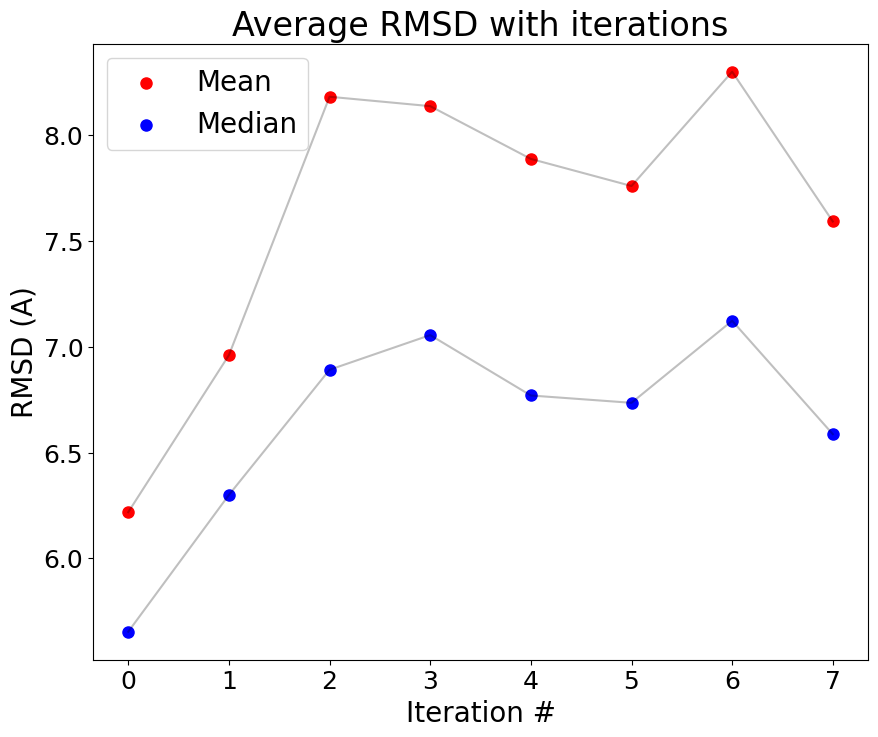

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(means)),means,c='k',alpha=0.25)
plt.plot(np.arange(len(medians)),medians,c='k',alpha=0.25)
plt.scatter(np.arange(len(means)),means,c='r',s=64,label="Mean")
plt.scatter(np.arange(len(medians)),medians,c='b',s=64,label="Median")
plt.legend(fontsize=20)
plt.title("Average RMSD with iterations",fontsize=24)
plt.xlabel("Iteration #",fontsize=20)
plt.xticks(np.arange(len(means)),np.arange(len(means)),fontsize=18)
plt.ylabel("RMSD (A)",fontsize=20)
plt.yticks(fontsize=18)
plt.savefig(ROOT_DIR+"/aggregate_figs/RMSD_mean_median.png")
#plt.plot(medians)

#### Draw a box plot of RMSD for each iteration

(0.0, 25.0)

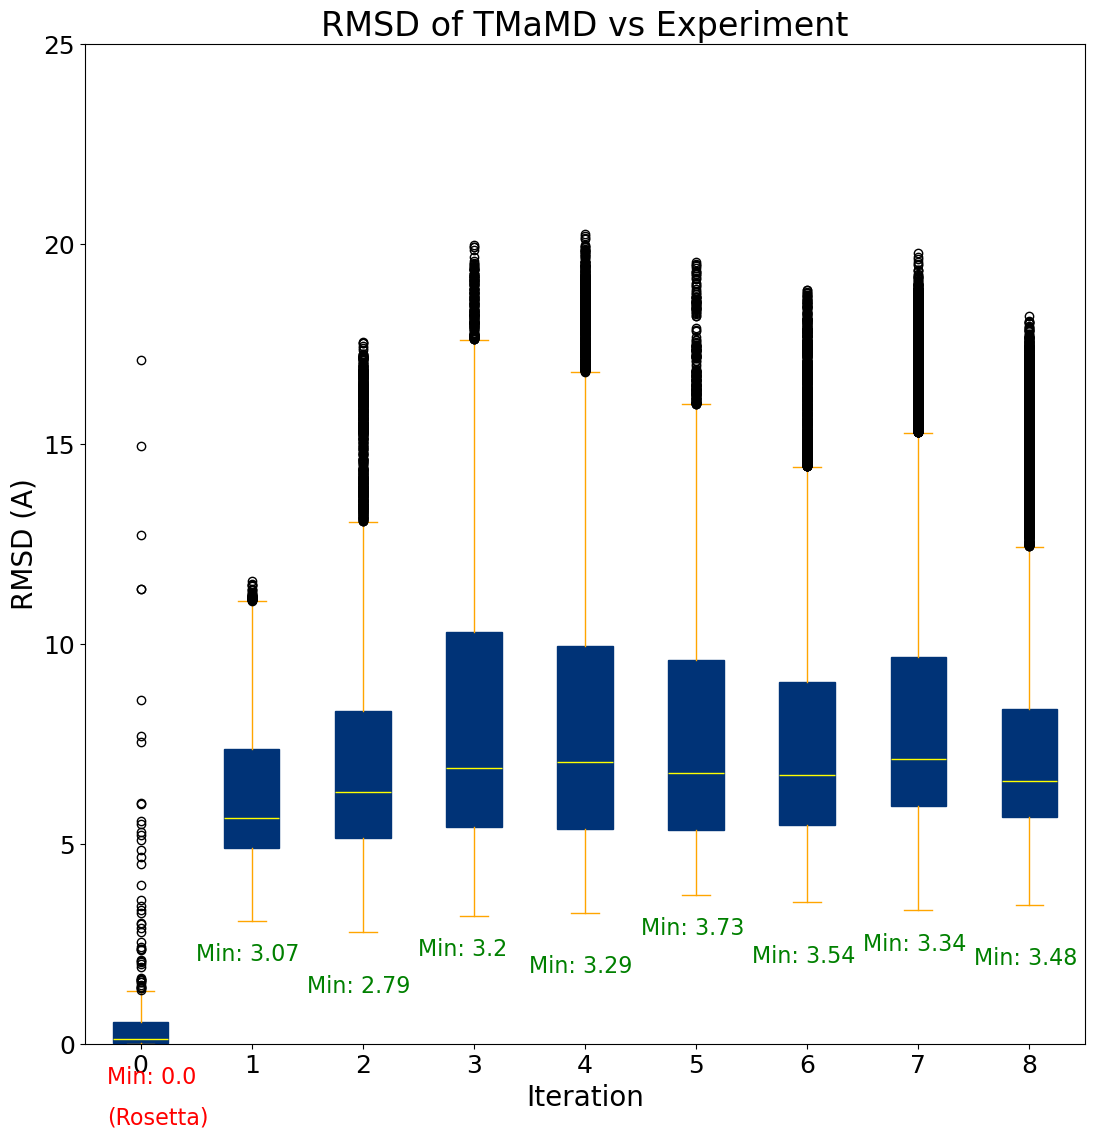

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
ax = plt.axes((0, 0, 1, 1))

BASELINE=False
Y_SHIFT=1.0 # TODO: Change accordingly (will depend on RMSD ranges. This determines where the text will go on screen)
EXTRA_SHIFT=0.5 # TODO: Change accordinly (Can change to make a good-looking plot. Staggers the text to space it)

# Optional section: TODO: Change accordingly (Only use if you want to add a baseline)
BASELINE=True
#baseline_rmsd=np.load(ROOT_DIR+"../../baseline_rmsds.npy")
baseline_rmsd=np.load(ROOT_DIR+"/rosetta/RMSD_crystal.npy")
baseline_rmsd=baseline_rmsd[~np.isnan(baseline_rmsd)]
ax.text(0.70,np.min(baseline_rmsd)-Y_SHIFT, "Min: "+str(round(np.min(baseline_rmsd),2)), fontsize=16, color='red')
ax.text(0.70,np.min(baseline_rmsd)-Y_SHIFT-1.0, "(Rosetta)", fontsize=16, color='red')
# End optional section

for i in range(len(minimums)):
    ax.text((1.50 if BASELINE else 0.5)+i,minimums[i]-Y_SHIFT-(i%2)*EXTRA_SHIFT, "Min: "+str(round(np.min(raw_data[i]),2)), fontsize=16, color='green')

if BASELINE: bplot=plt.boxplot([baseline_rmsd]+raw_data[:LEN_LIM],patch_artist=True,notch=False)
else: bplot=plt.boxplot(raw_data[:LEN_LIM],patch_artist=True,notch=False)
    
for i in range(len(bplot["boxes"])):
    bplot["boxes"][i].set_color("#003377")
    bplot["medians"][i].set_color("yellow")
[whisk.set_color("orange") for whisk in bplot["whiskers"]]
[whisk.set_color("orange") for whisk in bplot["caps"]]

if ANALYSIS_TYPE=="crystal": plt.title("RMSD of TMaMD vs Experiment",fontsize=24)
else: plt.title("RMSD of TMaMD vs Rosetta best",fontsize=24)
plt.yticks(fontsize=18)
plt.ylabel("RMSD (A)",fontsize=20)
plt.xticks(np.arange(len(bplot["boxes"]))+1,np.arange(len(bplot["boxes"])),fontsize=18)
plt.xlabel("Iteration",fontsize=20)
plt.ylim(0,25) # TODO: Change accordingly. (You can play with it to get a good looking plot.
plt.savefig(ROOT_DIR+"/aggregate_figs/RMSD_boxplot.png")

### Extras
Compare RMSD of the CASP15 best structure to the experimental stucture. You need:
- Crystal structure of predicted best pose

In [ ]:
ANALYSIS_TYPE="crystal"

In [ ]:
if ANALYSIS_TYPE!="crystal":
    print("WARN: You are comparing CASP best structure to rosetta prediction - not experimental pose")
    print("Rerun in 'crystal' analysis mode to get comparison to experimental pose")

In [ ]:
CASP_pred=LoadedPDB(ROOT_DIR+"../../CASP15_best.pdb") # TODO: Change accordingly 
aligned_CASP=align_poses(ref_pose,CASP_pred,silent=True,max_iter=1000,step_size=1e-1)
print("RMSD:",get_rmsd(ref_pose,aligned_CASP))